Notebook for prototyping $\mathrm{SE}(3)^N$ flow matching, also called frame matching.
Installation before running.

1. Go to `projects/sampling/experimental/jyim/se3_diffusion` and run `pip install -e .` from conda environment.
2. Other packages to install
  - `pip install dm-tree`
  - `pip install hydra-core --upgrade`
  - I may have missed a few. Install them as you need.
3. I'm able to import `from diffusion.corruption import so3_utils` directly but you may need to change the current working directory to be able to import this library.

# Imports

In [2]:
# Imports
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import dataclasses
import torch
from torch import nn
import time
import copy
import tree
from omegaconf import OmegaConf
from Bio import PDB
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from scipy.spatial.transform import Rotation 
import random
import pickle
from Bio import PDB

# Feynman imports
from diffusion.corruption import so3_utils

# FrameDiff imports
from data import utils as du
from data import parsers
from analysis import plotting
from model import ipa_pytorch
from openfold.utils.rigid_utils import Rigid
from data import all_atom
from openfold.data import data_transforms
from openfold.utils import rigid_utils
import analysis.utils as au

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utility methods

In [3]:
# SO(3) helper methods
def rotmat_to_skew_matrix(mat):
    vec = so3_utils.rotmat_to_rotvec(mat)
    return so3_utils.vector_to_skew_matrix(vec)

def skew_matrix_to_rotmat(skew):
    vec = so3_utils.skew_matrix_to_vector(skew)
    return so3_utils.rotvec_to_rotmat(vec)

def local_log(point, base_point):
    return rotmat_to_skew_matrix(
        torch.einsum(
            '...ij,...jk->...ik',
            rot_transpose(base_point), point
        )
    )
    
def multidim_trace(x):
    trace_mask = torch.zeros_like(x)
    trace_mask[..., torch.arange(3), torch.arange(3)] = 1.0
    return torch.sum(trace_mask * x, dim=(-1, -2))
    
def geodesic_dist(x, y):
    A = rotmat_to_skew_matrix(
        rot_mult(rot_transpose(x), y)
    )
    return torch.sqrt(
        multidim_trace(
            rot_mult(A, rot_transpose(A))
        )
    )
    
def rot_transpose(x):
    return torch.transpose(x, -1, -2)

def rot_mult(x, y):
    return torch.einsum('...ij,...jk->...ik', x, y)

def rot_vf(rot_t, rot_1):
    return so3_utils.rotmat_to_rotvec(
        torch.einsum(
            '...ij,...jk->...ik', rot_transpose(rot_t), rot_1)
    )

def geodesic_t(t, mat, base_mat):
    vec_vf = rot_vf(base_mat, mat)
    mat_t = so3_utils.rotvec_to_rotmat(t*vec_vf)
    return torch.einsum('...ij,...jk->...ik', base_mat, mat_t)

to_numpy = lambda x: x.detach().cpu().numpy()

ts = np.linspace(1e-3, 1.0, 100)


In [4]:
# Function for processing and parsing features from PDB files.
parser = PDB.PDBParser(QUIET=True)
def parse_pdb_file(pdb_path):
    structure = parser.get_structure('test', pdb_path)

    # Take out chain
    all_struct_chains = {
        chain.id.upper(): chain
        for chain in structure.get_chains()
    }
    struct_chain = all_struct_chains['A']

    # Get features
    chain_prot = parsers.process_chain(struct_chain, 'A')
    chain_dict = dataclasses.asdict(chain_prot)
    chain_dict = du.parse_chain_feats(chain_dict)

    # Extract frames
    chain_feats = {
        'aatype': torch.tensor(chain_dict['aatype']).long(),
        'all_atom_positions': torch.tensor(chain_dict['atom_positions']).double(),
        'all_atom_mask': torch.tensor(chain_dict['atom_mask']).double()
    }
    chain_feats = data_transforms.atom37_to_frames(chain_feats)
    chain_feats = data_transforms.make_atom14_masks(chain_feats)
    chain_feats = data_transforms.make_atom14_positions(chain_feats)
    chain_feats = data_transforms.atom37_to_torsion_angles()(chain_feats)

    # Feature processing
    final_feats = {
        'rigids_0': chain_feats['rigidgroups_gt_frames'][:, 0],
        'res_mask': chain_dict['bb_mask']
    }
    pad_mask = final_feats['res_mask'] > 0
    final_feats = tree.map_structure(lambda x: x[pad_mask], final_feats)
    return final_feats

# SE(3) Neural ODE on a protein 

In [5]:
final_feats = parse_pdb_file('1qys.pdb')

In [6]:
to_numpy = lambda x: x.cpu().numpy()

rigids_1 = rigid_utils.Rigid.from_tensor_4x4(final_feats['rigids_0'])
trans_1 = rigids_1.get_trans().float() / 10.0
mats_1 = rigids_1.get_rots().get_rot_mats().float()

num_res = trans_1.shape[0]

mats_0 = Rotation.random(num_res)
mats_0 = mats_0.as_matrix()
mats_0 = torch.tensor(mats_0).float()
trans_0 = torch.randn(num_res, 3).float()

np_trans_1 = to_numpy(trans_1)
np_mats_1 = to_numpy(mats_1)

r3_vf_t = lambda t, trans, trans_t: (trans - trans_t) / (1 - t)


In [7]:
# Run ODE
mats_1 = mats_1.float()
t_1 = ts[0]
manual_traj = [(mats_0.float(), trans_0)]
for t_2 in ts[1:]:
    d_t = t_2 - t_1
    mats_t, trans_t = manual_traj[-1]
    mats_t_1 = geodesic_t(d_t / (1 - t_1), mats_1, mats_t)
    trans_t_1 = trans_t + r3_vf_t(t_1, trans_1, trans_t) * d_t
    t_1 = t_2
    manual_traj.append((mats_t_1, trans_t_1))
trans_traj = [x[1] for x in manual_traj]
mats_traj = [x[0] for x in manual_traj]
trans_traj = torch.stack(trans_traj, dim=0).detach().numpy()
mats_traj = torch.stack(mats_traj, dim=0).detach().numpy()
vec_traj = so3_utils.rotmat_to_rotvec(torch.tensor(mats_traj)).numpy()

np.testing.assert_allclose(mats_traj[-1], mats_1, rtol=1e-2)
np.testing.assert_allclose(trans_traj[-1], trans_1, rtol=1e-2)


In [8]:
rots_t1_dist_traj = np.mean(to_numpy(geodesic_dist(
    torch.tensor(mats_traj),
    torch.tensor(mats_1[None])
)), axis=-1)

rots_t0_dist_traj = np.mean(to_numpy(geodesic_dist(
    torch.tensor(mats_traj),
    torch.tensor(mats_0[None])
)), axis=-1)

trans_t1_dist_traj = np.mean(np.linalg.norm(trans_traj - to_numpy(trans_1)[None], axis=-1), axis=-1)

trans_t0_dist_traj = np.mean(np.linalg.norm(trans_traj - to_numpy(trans_0)[None], axis=-1), axis=-1)


/tmp/ipykernel_13424/1747476978.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(mats_1[None])
/tmp/ipykernel_13424/1747476978.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(mats_0[None])


Text(0.5, 1.0, 'Protein SE(3) flow trajectories')

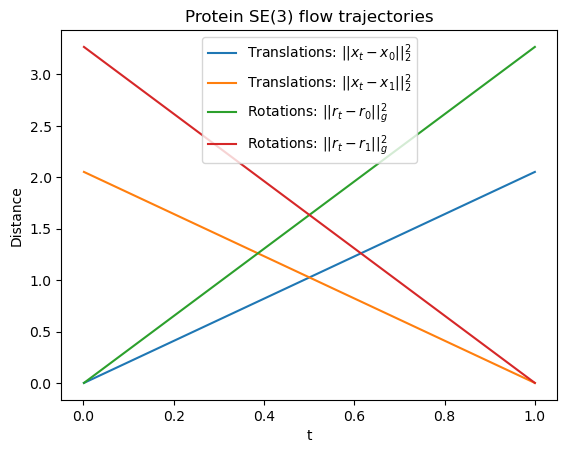

In [9]:
plt.plot(ts, trans_t0_dist_traj, label=r'Translations: $||x_t-x_0||_2^2$')
plt.plot(ts, trans_t1_dist_traj, label=r'Translations: $||x_t-x_1||_2^2$')  

plt.plot(ts, rots_t0_dist_traj, label=r'Rotations: $||r_t-r_0||_g^2$')
plt.plot(ts, rots_t1_dist_traj, label=r'Rotations: $||r_t-r_1||_g^2$')    
plt.xlabel('t')
plt.ylabel('Distance')
plt.legend()
plt.title('Protein SE(3) flow trajectories')

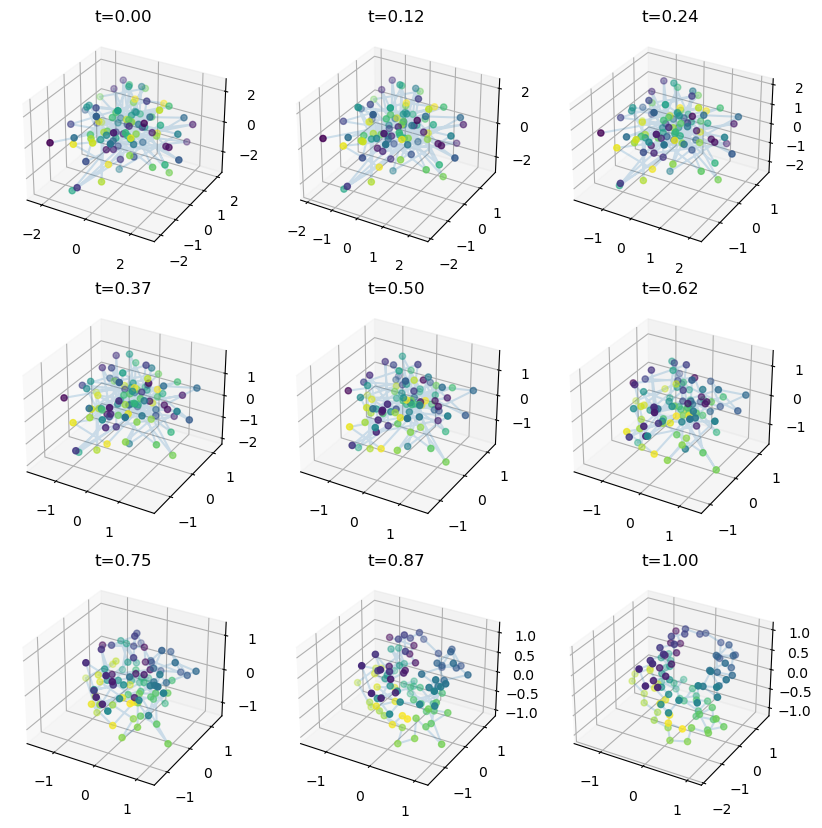

In [10]:
fig = plt.figure(figsize=(10, 10))
t_indices = [int(x) for x in np.linspace(0, 100-1, 9)]
for i,t_idx in enumerate(t_indices):
    t = ts[t_idx]
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    plotting.plt_3d(trans_traj[t_idx], ax, c=np.linspace(0, 1, num_res), mode='scatter', s=20)
    plotting.plt_3d(trans_traj[t_idx], ax, mode='line', s=30)
    ax.set_title(f't={t:.2f}')


In [29]:
rots = rigid_utils.Rotation(rot_mats = torch.tensor(mats_traj))
rigids = rigid_utils.Rigid(rots=rots, trans=torch.tensor(trans_traj)*10.0)

atom37_0 = all_atom.compute_backbone(
    rigids,
    torch.zeros(trans_traj.shape[0], trans_traj.shape[1], 2)
)[0]

traj = to_numpy(atom37_0) 

# Save flow to PDB
saved_path = au.write_prot_to_pdb(
    traj,
    './ode_traj.pdb',
    no_indexing=True,
)

# Save flow to PDB
saved_path = au.write_prot_to_pdb(
    traj[-1],
    './ode_final.pdb',
    no_indexing=True,
)


# Learn SE(3) flow matching

## Data

In [162]:
class FlowDataset(Dataset):
    def __init__(
            self, prot_feats, steps, scale_factor,
            crop=100, noise_trans=True, noise_rots=True
        ):
        self.prot_feats = prot_feats
        self.steps = steps
        self.scale_factor = scale_factor
        self.crop = crop
        self.noise_trans = noise_trans
        self.noise_rots = noise_rots

    def __len__(self):
        return self.steps   

    def __getitem__(self, i):
        t = random.random()
        prot_feats = self.prot_feats[i % len(self.prot_feats)]
        num_res = prot_feats['res_mask'].shape[0]
        gt_bb_rigid = rigid_utils.Rigid.from_tensor_4x4(
            prot_feats['rigids_0'])
        
        final_feats = copy.deepcopy(prot_feats)
        
        # Scaled translations
        # Scale down to nm
        final_feats['trans_1'] = gt_bb_rigid.get_trans() * self.scale_factor
        final_feats['trans_0'] = torch.randn(num_res, 3)
        if self.noise_trans:
            final_feats['trans_t'] = (1 - t) * final_feats['trans_0'] + t * final_feats['trans_1']
        else:
            final_feats['trans_t'] = final_feats['trans_1']
        final_feats['trans_vf'] = final_feats['trans_1'] - final_feats['trans_t']
        
        final_feats['rots_1'] = gt_bb_rigid.get_rots().get_rot_mats().float()
        final_feats['rots_0'] = torch.tensor(
            Rotation.random(num_res).as_matrix()).float()
        if self.noise_rots:
            final_feats['rots_t'] = geodesic_t(
                t, final_feats['rots_1'], final_feats['rots_0'])
        else:
            final_feats['rots_t'] = final_feats['rots_1']
        final_feats['rots_vf'] = rot_vf(
            final_feats['rots_t'],
            final_feats['rots_1']
        )

        rots = rigid_utils.Rotation(rot_mats=final_feats['rots_t'])
        final_feats['rigids_t'] = rigid_utils.Rigid.to_tensor_4x4(
            rigid_utils.Rigid(
                rots=rots,
                # Scale up to angstroms
                trans=final_feats['trans_t'] / self.scale_factor
            )
        )

        def _map(x):
            x = torch.tensor(x).type(torch.float32)
            if self.crop is not None:
                return x[:self.crop]
            return x
        final_feats = tree.map_structure(_map, final_feats)
        final_feats['t'] = torch.tensor(t)[None].type(torch.float32)
        return final_feats

## Model

In [117]:

def get_index_embedding(indices, embed_size, max_len=2056):
    """Creates sine / cosine positional embeddings from a prespecified indices.

    Args:
        indices: offsets of size [..., N_edges] of type integer
        max_len: maximum length.
        embed_size: dimension of the embeddings to create

    Returns:
        positional embedding of shape [N, embed_size]
    """
    K = torch.arange(embed_size//2, device=indices.device)
    pos_embedding_sin = torch.sin(
        indices[..., None] * math.pi / (max_len**(2*K[None]/embed_size))).to(indices.device)
    pos_embedding_cos = torch.cos(
        indices[..., None] * math.pi / (max_len**(2*K[None]/embed_size))).to(indices.device)
    pos_embedding = torch.cat([
        pos_embedding_sin, pos_embedding_cos], axis=-1)
    return pos_embedding

def get_timestep_embedding(timesteps, embedding_dim, max_positions=1000):
    # Code from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py
    assert len(timesteps.shape) == 1
    timesteps = timesteps * max_positions
    half_dim = embedding_dim // 2
    emb = math.log(max_positions) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1), mode='constant')
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

class VFModel(nn.Module):

    def __init__(self, model_conf):
        super(VFModel, self).__init__()
        self._model_conf = model_conf
        self._ipa_conf = model_conf.ipa
        self.scale_pos = lambda x: x * ipa_conf.coordinate_scaling
        self.scale_rigids = lambda x: x.apply_trans_fn(self.scale_pos)

        self.unscale_pos = lambda x: x / ipa_conf.coordinate_scaling
        self.unscale_rigids = lambda x: x.apply_trans_fn(self.unscale_pos)
        
        node_embed_size = self._model_conf.node_embed_size
        self.node_embedder = nn.Sequential(
            nn.Linear(node_embed_size*2, node_embed_size),
            nn.ReLU(),
            nn.Linear(node_embed_size, node_embed_size),
            nn.ReLU(),
            nn.Linear(node_embed_size, node_embed_size),
            nn.LayerNorm(node_embed_size),
        )
        
        self.trunk = nn.ModuleDict()

        for b in range(ipa_conf.num_blocks):
            self.trunk[f'ipa_{b}'] = ipa_pytorch.InvariantPointAttention(ipa_conf)
            self.trunk[f'ipa_ln_{b}'] = nn.LayerNorm(ipa_conf.c_s)
            self.trunk[f'skip_embed_{b}'] = ipa_pytorch.Linear(
                self._model_conf.node_embed_size,
                self._ipa_conf.c_skip,
                init="final"
            )
            tfmr_in = ipa_conf.c_s + self._ipa_conf.c_skip
            tfmr_layer = torch.nn.TransformerEncoderLayer(
                d_model=tfmr_in,
                nhead=ipa_conf.seq_tfmr_num_heads,
                dim_feedforward=tfmr_in,
                batch_first=True,
                dropout=0.0,
                norm_first=False
            )
            self.trunk[f'seq_tfmr_{b}'] = torch.nn.TransformerEncoder(
                tfmr_layer, ipa_conf.seq_tfmr_num_layers)
            self.trunk[f'post_tfmr_{b}'] = ipa_pytorch.Linear(
                tfmr_in, ipa_conf.c_s, init="final")
            self.trunk[f'node_transition_{b}'] = ipa_pytorch.StructureModuleTransition(
                c=ipa_conf.c_s)
            self.trunk[f'bb_update_{b}'] = ipa_pytorch.BackboneUpdate(ipa_conf.c_s)

            if b < ipa_conf.num_blocks-1:
                # No edge update on the last block.
                edge_in = self._model_conf.edge_embed_size
                self.trunk[f'edge_transition_{b}'] = ipa_pytorch.EdgeTransition(
                    node_embed_size=ipa_conf.c_s,
                    edge_embed_in=edge_in,
                    edge_embed_out=self._model_conf.edge_embed_size,
                )

    def forward(self, input_feats):
        # Initial node and edge features
        node_mask = input_feats['res_mask'].type(torch.float32)
        num_batch = node_mask.shape[0]
        num_res = node_mask.shape[1]
        node_indices = torch.arange(num_res)
        index_embed = get_index_embedding(
            node_indices, self._model_conf.node_embed_size
        )[None].repeat(num_batch, 1, 1).type(torch.float32).to('cuda')
        t_embed = get_timestep_embedding(
            input_feats['t'][:, 0],
            self._model_conf.node_embed_size
        )[:, None, :].repeat(1, num_res, 1).type(torch.float32).to('cuda')
        init_node_feats = torch.concat(
            [index_embed, t_embed], dim=-1)
        init_node_embed = self.node_embedder(
            init_node_feats
        )
        
        edge_mask = node_mask[..., None] * node_mask[..., None, :]
        edge_embed = init_node_embed[:, :, None, :] + init_node_embed[:, None, :, :]
        edge_embed = edge_embed.type(torch.float32)

        # Initial rigids
        init_frames = input_feats['rigids_t'].type(torch.float32)
        rigids_t = Rigid.from_tensor_4x4(torch.clone(init_frames))
        curr_rigids = Rigid.from_tensor_4x4(torch.clone(init_frames))

        # Main trunk
        curr_rigids = self.scale_rigids(curr_rigids)
        init_node_embed = init_node_embed * node_mask[..., None]
        node_embed = init_node_embed * node_mask[..., None]
        for b in range(self._ipa_conf.num_blocks):
            ipa_embed = self.trunk[f'ipa_{b}'](
                node_embed,
                edge_embed,
                curr_rigids,
                node_mask)
            ipa_embed *= node_mask[..., None]
            node_embed = self.trunk[f'ipa_ln_{b}'](node_embed + ipa_embed)
            seq_tfmr_in = torch.cat([
                node_embed, self.trunk[f'skip_embed_{b}'](init_node_embed)
            ], dim=-1)
            seq_tfmr_out = self.trunk[f'seq_tfmr_{b}'](
                seq_tfmr_in, src_key_padding_mask=1 - node_mask)
            node_embed = node_embed + self.trunk[f'post_tfmr_{b}'](seq_tfmr_out)
            node_embed = self.trunk[f'node_transition_{b}'](node_embed)
            node_embed = node_embed * node_mask[..., None]
            rigid_update = self.trunk[f'bb_update_{b}'](
                node_embed * node_mask[..., None])
            curr_rigids = curr_rigids.compose_q_update_vec(
                rigid_update, node_mask[..., None])

            if b < self._ipa_conf.num_blocks-1:
                edge_embed = self.trunk[f'edge_transition_{b}'](
                    node_embed, edge_embed)
                edge_embed *= edge_mask[..., None]
        
        pred_trans = curr_rigids.get_trans()
        trans_t = rigids_t.get_trans()
        trans_vf = pred_trans - trans_t
        pred_rots = curr_rigids.get_rots().get_rot_mats()
        rots_t = rigids_t.get_rots().get_rot_mats()
        rots_vf = rot_vf(rots_t, pred_rots)
        return {
            'trans_vf': trans_vf,
            'rots_vf': rots_vf,
            'pred_trans': pred_trans,
            'pred_rots': pred_rots
        }


## Training

In [76]:
top7_feats = parse_pdb_file('1qys.pdb')
efhand_feats = parse_pdb_file('1b9a.pdb')
bet_feats = parse_pdb_file('5o3a.pdb')

In [249]:

# Load config
base_conf = OmegaConf.load('/home/t-jasonyim/projects/feynman/projects/sampling/experimental/jyim/se3_diffusion/config/base.yaml')
model_conf = base_conf.model
ipa_conf = model_conf.ipa

scale_factor = 0.1

# Small model config
embed_size = 64
model_conf.node_embed_size = embed_size
model_conf.edge_embed_size = embed_size
ipa_conf.c_hidden = embed_size
ipa_conf.c_skip = 32
ipa_conf.no_heads = 2
ipa_conf.no_qk_points = 8
ipa_conf.no_v_points = 8
ipa_conf.seq_tfmr_num_heads = 2
ipa_conf.seq_tfmr_num_layers = 1
ipa_conf.num_blocks = 2
ipa_conf.coordinate_scaling = scale_factor

# Initialize model
model = VFModel(model_conf)
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters())

# Construct dataset
noise_trans = True
noise_rots = True
flow_dataset = FlowDataset(
    [top7_feats, efhand_feats],
    # [top7_feats, efhand_feats, bet_feats],
    1_000_000,
    scale_factor,
    crop=90,
    noise_trans=noise_trans,
    noise_rots=noise_rots,
)
train_dataloader = DataLoader(flow_dataset, batch_size=64)

In [250]:
all_losses = []
all_ts = []
all_rot_losses = []
all_trans_losses = []
epoch_losses = []

In [ ]:

# Train loop
start_time = time.time()
print_interval = 500
for i, feats in enumerate(train_dataloader):
    feats = tree.map_structure(lambda x: x.to('cuda'), feats)
    gt_trans_vf = feats['trans_vf']
    gt_rots_vf = feats['rots_vf']

    optimizer.zero_grad()
    model_out = model(feats)
    pred_trans_vf = model_out['trans_vf']
    pred_rots_vf = model_out['rots_vf']
    if noise_trans:
        trans_loss = torch.mean(
            (model_out['pred_trans'] - feats['trans_1']) ** 2
        )
    else:
        trans_loss = torch.tensor(0)

    if noise_rots:
        rots_loss = torch.mean((pred_rots_vf - gt_rots_vf) ** 2)
    else:
        rots_loss = torch.tensor(0)
    vf_loss = trans_loss + rots_loss
    vf_loss.backward()
    optimizer.step()

    step_loss = to_numpy(vf_loss)
    all_losses.append(step_loss)
    all_rot_losses.append(to_numpy(rots_loss))
    all_trans_losses.append(to_numpy(trans_loss))
    all_ts.append(to_numpy(feats['t']))
    epoch_losses.append(step_loss)
    if i % print_interval == 0:
        epoch_time = time.time() - start_time
        print(f'On step {i}: loss={np.mean(epoch_losses):.2f}, time={print_interval/epoch_time:.2f}(steps/sec)')
        start_time = time.time()
        epoch_losses = []


Text(0, 0.5, 'Loss')

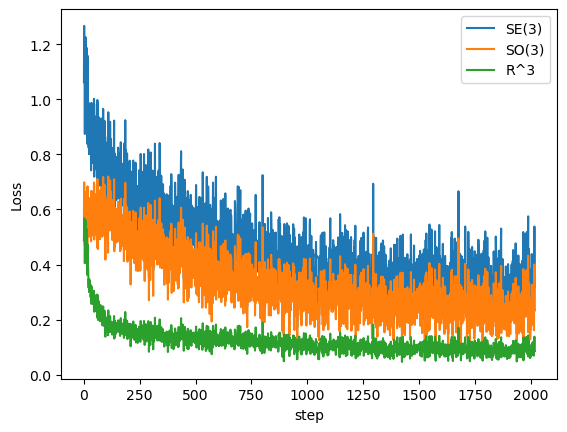

In [252]:
plt.plot(all_losses, label='SE(3)')
plt.plot(all_rot_losses, label='SO(3)')
plt.plot(all_trans_losses, label='R^3')
plt.legend()
plt.xlabel('step')
plt.ylabel('Loss')

In [214]:
# Save weights
pkl_path = 'weights.pth'
pkl_dict = {
    'model': copy.deepcopy(model.state_dict()),
    'conf': model_conf,
}
torch.save(pkl_dict, pkl_path, pickle_protocol=pickle.HIGHEST_PROTOCOL)

## Sampling

In [144]:
# loaded_weights = torch.load(pkl_path, map_location='cuda')
# model = VFModel(loaded_weights['conf'])
# model = sample_model.to('cuda')
# model.load_state_dict(loaded_weights['model'], strict=True)

<All keys matched successfully>

In [265]:
# Pseudo features
feats = next(iter(train_dataloader))
feats = tree.map_structure(lambda x: x[:1].to('cuda'), feats)
num_batch, num_res = feats['res_mask'].shape[:2]

trans_0 = torch.randn(num_batch, num_res, 3)

if noise_trans:
    feats['trans_t'] = copy.deepcopy(trans_0)
else:
    feats['trans_t'] = feats['trans_1']
feats['trans_t'] = feats['trans_t'].to('cuda')
rots_0 = torch.tensor(
    Rotation.random(num_res).as_matrix()).float()

if noise_rots:
    feats['rots_t'] = copy.deepcopy(rots_0)[None].repeat(num_batch, 1, 1, 1)
else:
    feats['rots_t'] = feats['rots_1']
feats['rots_t'] = feats['rots_t'].to('cuda')

rots = rigid_utils.Rotation(rot_mats=feats['rots_t'])
feats['rigids_t'] = rigid_utils.Rigid.to_tensor_4x4(
    rigid_utils.Rigid(
        rots=rots,
        # Scale up to angstroms
        trans=feats['trans_t'] / scale_factor
    )
)

/tmp/ipykernel_10241/3157687487.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).type(torch.float32)


In [266]:
def create_rigid(rots, trans):
    rots = rigid_utils.Rotation(rot_mats=rots)
    return rigid_utils.Rigid.to_tensor_4x4(
        rigid_utils.Rigid(
            rots=rots, trans=trans
        )
    )
r3_vf_t = lambda t, trans, trans_t: (trans - trans_t) / (1 - t)

In [267]:
rigids_traj = [copy.deepcopy(feats['rigids_t']).to('cuda')]
ts = np.linspace(1e-3, 1.0, 100)
t_1 = ts[0]
for t_2 in ts[1:]:
    d_t = t_2 - t_1
    rigids_t_1 = rigids_traj[-1]

    with torch.no_grad():
        feats['rigids_t'] = rigids_t_1
        feats['t'] = torch.ones_like(feats['t']) * t_1
        model_out = model(feats)
    rigids_t_1 = Rigid.from_tensor_4x4(rigids_t_1)
    
    # pred_trans_1 = feats['trans_1']
    # pred_rots_1 = feats['rots_1']
    pred_trans_1 = model_out['pred_trans']
    pred_rots_1 = model_out['pred_rots']

    # Perform translation updates in scaled coordinates (nm)
    trans_t_1 = rigids_t_1.get_trans() * scale_factor
    if noise_trans:
        trans_t_2 = trans_t_1 + r3_vf_t(t_1, pred_trans_1, trans_t_1) * d_t
    else:
        trans_t_2 = trans_t_1
    # Scale back up since IPA expects angstroms.
    trans_t_2 /= scale_factor
    
    rots_t_1 = rigids_t_1.get_rots().get_rot_mats()
    if noise_rots:
        rots_t_2 = geodesic_t(d_t / (1 - t_1), pred_rots_1, rots_t_1)
    else:
        rots_t_2 = rots_t_1
    t_1 = t_2
    rigids_traj.append(
        copy.deepcopy(
            create_rigid(
                rots_t_2, trans_t_2
            )
        ).to('cuda')
    )


In [268]:
all_trans = []
all_rots = []
for rigid in rigids_traj:
    rigid = Rigid.from_tensor_4x4(rigid)
    trans = rigid.get_trans()
    rots = rigid.get_rots().get_rot_mats()
    all_trans.append(trans)
    all_rots.append(rots)
trans_traj = torch.concatenate(all_trans)
rots_traj = torch.concatenate(all_rots)
rots = rigid_utils.Rotation(rot_mats = rots_traj)
rigids = rigid_utils.Rigid(rots=rots, trans=trans_traj)

In [269]:
atom37_0 = all_atom.compute_backbone(
    rigids,
    torch.zeros(trans_traj.shape[0], trans_traj.shape[1], 2)
)[0]

traj = to_numpy(atom37_0) 

# Save flow to PDB
saved_path = au.write_prot_to_pdb(
    traj,
    './sample_traj_2.pdb',
    no_indexing=True,
)

# Save flow to PDB
saved_path = au.write_prot_to_pdb(
    traj[-1],
    './sample_2.pdb',
    no_indexing=True,
)

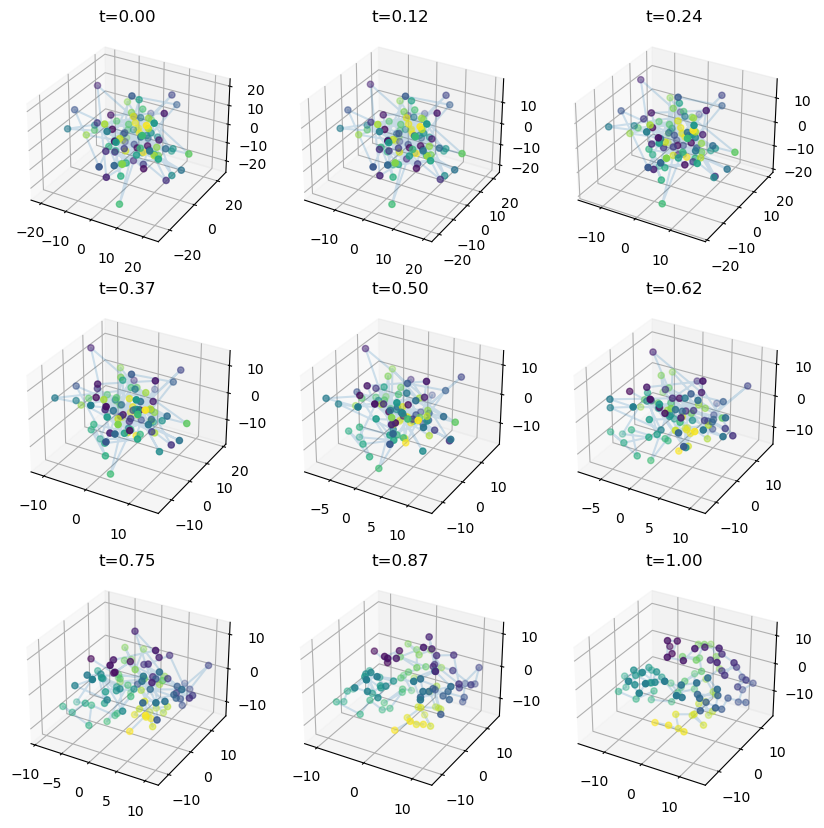

In [270]:

np_trans_traj = to_numpy(trans_traj)
fig = plt.figure(figsize=(10, 10))
t_indices = [int(x) for x in np.linspace(0, len(ts)-1, 9)]
for i,t_idx in enumerate(t_indices):
    t = ts[t_idx]
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    plotting.plt_3d(np_trans_traj[t_idx], ax, c=np.linspace(0, 1, num_res), mode='scatter', s=20)
    plotting.plt_3d(np_trans_traj[t_idx], ax, mode='line', s=30)
    ax.set_title(f't={t:.2f}')
